In [94]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


### 데이터 로드

In [95]:
DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [96]:
x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

In [97]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [98]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


### Visualization 

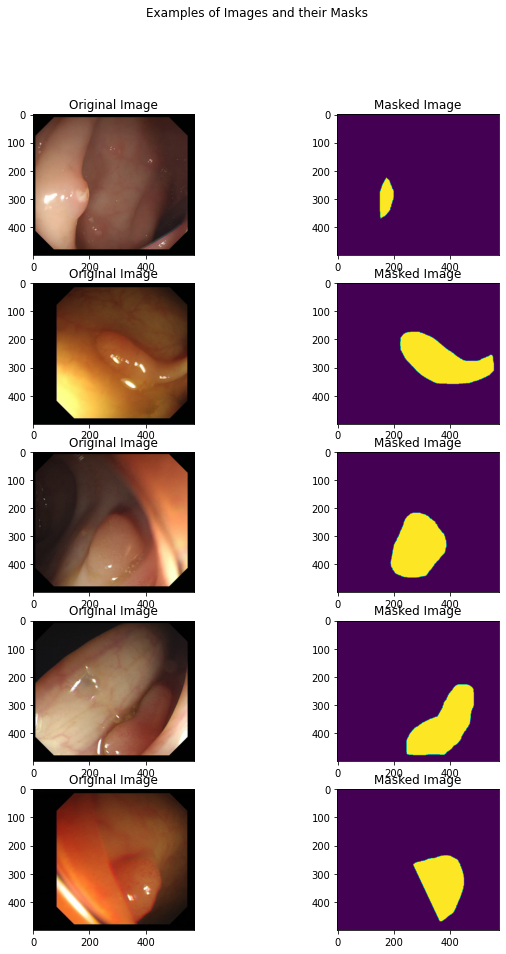

In [99]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

### Data pipeline and Preprocessing

In [100]:
# Set hyperparameters

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

#### tf.data를 활용한 입력 파이프라인 설계
오늘 우리는 tf.data.Dataset을 이용해 데이터셋 구축, 배치처리 등을 진행할 것입니다. 이 과정에서 다양한 함수를 map에 적용하여 Data Augmentation을 함께 구현할 것입니다.

다음과 같은 과정으로 진행하겠습니다. 이 과정은 tf.data에 대한 텐서플로우 튜토리얼에 소개된 내용을 정리한 것입니다.

1. 이미지와 레이블 모두 파일 이름에서 파일의 바이트를 읽습니다. 라벨은 실제로 각 픽셀이 용종데이터로 (1, 0)으로 주석이 달린 이미지입니다.
2. 바이트를 이미지 형식으로 디코딩합니다.
3. augment 함수를 통한 이미지 변환 적용 : (optional, input parameters에 따라서)
- resize-이미지를 표준 크기로 조정합니다 (eda 또는 계산 / 메모리 제한에 의해 결정됨)
- resize의 이유는 U-Net이 fully convolution networks 이므로 입력 크기에 의존하지 않습니다. 그러나 이미지 크기를 조정하지 않으면 가변 이미지 크기를 함께 배치 할 수 없으므로 배치 크기 1을 사용해야합니다.
- 성능에 영향을 줄 수 있으므로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정할 수도 있습니다.
- hue_delta-RGB 이미지의 색조를 랜덤 팩터로 조정합니다. 이것은 실제 이미지에만 적용됩니다 (라벨 이미지가 아님). hue_delta는[0, 0.5]간격에 있어야합니다.
- horizontal_flip-0.5 확률로 중심 축을 따라 이미지를 수평으로 뒤집습니다. 이 변환은 레이블과 실제 이미지 모두에 적용해야합니다.
- width_shift_range 및height_shift_range는 이미지를 가로 또는 세로로 임의로 변환하는 범위 (전체 너비 또는 높이의 일부)입니다. 이 변환은 레이블과 실제 이미지 모두에 적용해야 합니다.
- rescale-이미지를 일정한 비율로 다시 조정합니다 (예 : 1/255.)
데이터를 섞고, 데이터를 반복하여 학습합니다.

##### Processing each pathname
실제 이미지 데이터를 로드하는 함수를 구현해 봅시다. 이 함수 안에서는 다음과 같은 작업을 수행합니다.

- byte 형태로 데이터를 로드하고, bmp로 디코딩합니다.
- 디코딩이 완료된 image를 scale과 size를 조절합니다.

In [101]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3) #bmp로 디코딩 

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3)
    label_img = tf.image.rgb_to_grayscale(label_img)

    # scale과 size 조절
    resize = [image_size, image_size]
    img = tf.image.resize(img, resize) 
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

##### Data augmentation - Shifting the image
아래는 로드한 이미지를 기반으로 이미지의 위치를 적절히 이동(shift)시키는 함수입니다. 입력이미지와 라벨의 쌍을 동일하게 shift시켜주어야 합니다.

In [102]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range: # 가로로 이동할 거리를 랜덤하게 정함 width_shift_range=0.2라면 
                width_shift_range = tf.random.uniform([], # -20% ~ 20% 
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

##### Data augmentation - Flipping the image randomly
아래는 로드한 이미지를 기반으로 이미지를 flip하는 함수입니다. 50%의 확률로 좌우반전만 구현하였고, 상하반전은 적용하지 않았습니다.

In [103]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

##### Data augmentation Assembling
위에서 구현한 Augmentation용 함수를 이용해 Data augmentation에 사용하는 _augment() 함수를 구성합니다. 위에서 적용한 것들 이외에도 resize, hue_delta가 적용됩니다.

In [104]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta) #색조 변화 hue_delta가 0.1이면 -0.1~0.1 범위
  
    img, label_img = flip_img(horizontal_flip, img, label_img) # 좌우반전
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

##### Set up train and test datasets
이제 tf.data.Dataset을 이용하여 데이터셋 배치구성, 셔플링 등을 구현합니다. 이때 위에서 만들어온 augmentation도 함께 적용됩니다. 단, Train dataset에서만 Data augmentation을 진행하게 설정하는 것에 주의해 주세요.






In [105]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        #  assert batch_size == 1, "Batching images must be of the same size"
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

In [106]:
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 정답 데이터
train_dataset = train_dataset.repeat()
test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

#### Plot some train data
지금까지 구성한 학습 데이터를 확인해 봅시다. 특히 data augmentation 효과가 잘 적용되었을지 눈여겨 보도록 합시다.

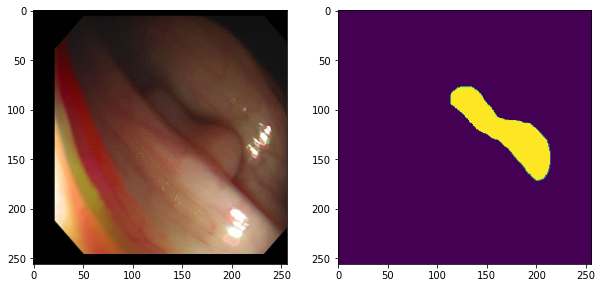

In [107]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

## Build the model
1. Encoder-Decoder architecture
2. U-Net

### Encoder-Decoder architecture
- Encoder를 이용해 우리가 가진 Train data를 작은 차원의 공간에 압축하는 방식으로 동작합니다.
- Decoder는 Encoder가 압축한 데이터들을 우리가 원하는 label 데이터와 같도록 재생성합니다.
- 이렇게 생성된 데이터와 label 간의 차이가 작아지도록 Encoder와 Decoder의 파라미터들이 End-to-End로 학습됩니다.
![](https://d3s0tskafalll9.cloudfront.net/media/images/e-20-2.max-800x600.png)

##### Encoder 
- input data의 shape가 다음과 같이 되도록 네트워크를 구성합니다.
inputs = [batch_size, 256, 256, 3]

conv1 = [batch_size, 128, 128, 64]

conv2 = [batch_size, 64, 64, 128]

conv3 = [batch_size, 32, 32, 256]

outputs = [batch_size, 16, 16, 512]

- Convolution - Normalization - Activation 등의 조합을 다양하게 생각해 봅시다.
- Encoder의 차원을 줄여가는 방법으로 Pooling을 쓸지 Convolution with stride=2 로 할지 선택해 볼 수 있습니다.
- tf.keras.Sequential()을 이용하여 만들어 봅시다.

##### Decoder
- Encoder의 mirror 형태로 만들어 봅시다.
- input data의 shape이 다음과 같이 되도록 네트워크를 구성합니다.
inputs = encoder의 outputs = [batch_size, 16, 16, 512]

conv_transpose1 = [batch_size, 32, 32, 256]

conv_transpose2 = [batch_size, 64, 64, 128]

conv_transpose3 = [batch_size, 128, 128, 64]

- outputs = [batch_size, 256, 256, 1]
- tf.keras.Sequential()을 이용하여 만들어 봅시다.





In [108]:
# inputs: [batch_size, 256, 256, 3]
encoder = tf.keras.Sequential(name='encoder')

# conv-batchnorm-activation-maxpool
encoder.add(layers.Conv2D(64, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(64, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv1: [batch_size, 128, 128, 64]

encoder.add(layers.Conv2D(128, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv2: [batch_size, 64, 64, 128]

encoder.add(layers.Conv2D(256, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv3: [batch_size, 32, 32, 256]

encoder.add(layers.Conv2D(512, (3, 3), padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu'))
encoder.add(layers.Conv2D(512, (3, 3), strides=2, padding='same'))
encoder.add(layers.BatchNormalization())
encoder.add(layers.Activation('relu')) # conv4-outputs: [batch_size, 16, 16, 512]

In [109]:
# inputs: [batch_size, 16, 16, 512]
decoder = tf.keras.Sequential(name='decoder')

# conv_transpose-batchnorm-activation
decoder.add(layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose1: [batch_size, 32, 32, 256]
decoder.add(layers.Conv2D(256, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose2: [batch_size, 64, 64, 128]
decoder.add(layers.Conv2D(128, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv_transpose3: [batch_size, 128, 128, 64]
decoder.add(layers.Conv2D(64, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu')) # conv transpose4-outputs: [batch_size, 256, 256, 32]
decoder.add(layers.Conv2D(32, (3, 3), padding='same'))
decoder.add(layers.BatchNormalization())
decoder.add(layers.Activation('relu'))

decoder.add(layers.Conv2DTranspose(1, 1, strides=1, padding='same', activation='sigmoid'))

In [110]:
# Encoder 제대로 만들어졌는지 확인

bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
print(bottleneck.shape)   # (batch_size, 16, 16, 512) 이 나오는지 확인

# decoder 제대로 만들어졌는지 확인

predictions = decoder(bottleneck)
print(predictions.shape)    # (batch_size, 256, 256, 1) 이 나오는지 확인

(8, 16, 16, 512)
(8, 256, 256, 1)


In [111]:
#둘을 결합
ed_model = tf.keras.Sequential()

ed_model.add(encoder)
ed_model.add(decoder)

### U-Net architecture

오늘 우리가 만들어볼 U-Net 모델구조는 아래 그림과 같습니다. 잘 보면 U-Net 원본과는 약간 차이가 있습니다. 논문 원본의 구현에서는 padding을 zero로 하기 때문에 Encoder 레이어 대비 Decoder 레이어에 약간의 사이즈 축소가 발생합니다. 그러나 우리는 padding을 same으로 두고 Encoder, Decoder간 대응하는 레이어의 사이즈를 동일하게 가져갈 것입니다. 이것은 크게 성능에 영향을 주지 않으면서도 구현이 용이할 뿐더러 이후 모델의 추가개선을 더욱 쉽게 만들어 주는 장점이 있습니다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/e-20-3.max-800x600.png)

#### Model subclassing을 활용한 구현
- U-Net은 Encoder-Decoder 구조와는 달리 해당 레이어의 outputs이 바로 다음 레이어의 inputs이 되지 않습니다. 이럴때는 위에 Encoder-Decoder 모델처럼 tf.keras.Sequential()을 쓸 수가 없게 됩니다.

- Sequential 구조가 아닌 네트워크를 만들 때 쓸 수 있는 API 가 바로 tf.keras functional API 입니다. 오늘 우리는 U-Net 구현을 위해 Model subclassing 방식을 사용하여, tf.keras.Model 클래스를 상속하여 구현할 것입니다.

In [112]:
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x

In [113]:
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)

        return encoder

class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)

        return decoder


class EncoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(num_filters)
        self.encoder_pool = layers.MaxPool2D()

    def call(self, inputs, training=True):
        encoder = self.conv_block(inputs, training=training)
        encoder_pool = self.encoder_pool(encoder)

        return encoder_pool, encoder


class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder

In [114]:
class UNet(tf.keras.Model):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_block1 = EncoderBlock(64)
        self.encoder_block2 = EncoderBlock(128)
        self.encoder_block3 = EncoderBlock(256)
        self.encoder_block4 = EncoderBlock(512)

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):
        encoder1_pool, encoder1 = self.encoder_block1(inputs)
        encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool)
        encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool)
        encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool)

        center = self.center(encoder4_pool)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs

In [115]:
unet_model = UNet()

### metrics과 loss functions 정의하기
우리가 사용할 loss function은 다음과 같습니다.

- binary cross entropy

- dice_loss

Image Segmentation Task에서 정답을 더 잘 찾아내기위해 새로운 Loss를 추가해 사용한다.
논문에 나온 Dice coefficient 수식

- Cross-entropy loss와 Dice loss를 같이 사용해 meanIoU를 더 올리도록 학습할 수 있다.

In [116]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [117]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [118]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [119]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

In [120]:
# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요. 
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다. 

#print('select the Encoder-Decoder model')
#model = ed_model
#checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

print('select the U-Net model')
model = unet_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/unet_model')

select the U-Net model


In [121]:
# model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
# predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
# print(predictions.shape)
# model.summary()

(8, 256, 256, 1)
Model: "u_net_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block_8 (EncoderBloc multiple                  76416     
_________________________________________________________________
encoder_block_9 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_10 (EncoderBlo multiple                  1773312   
_________________________________________________________________
encoder_block_11 (EncoderBlo multiple                  7085568   
_________________________________________________________________
conv_block_15 (ConvBlock)    multiple                  28326912  
_________________________________________________________________
decoder_block_12 (DecoderBlo multiple                  18882048  
_________________________________________________________________
decoder_block_13 (DecoderBlo multiple     

In [122]:
# if not os.path.isdir(checkpoint_dir):
#     os.makedirs(checkpoint_dir)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
#                                                  save_weights_only=True,
#                                                  monitor='val_loss',
#                                                  mode='auto',
#                                                  save_best_only=True,
#                                                  verbose=0)

In [123]:
# cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
#                                               max_epochs)
# lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [124]:
# ## Define print function
# def print_images():
#     for test_images, test_labels in test_dataset.take(1):
#         predictions = model(test_images, training=False)

#         plt.figure(figsize=(10, 20))
#         plt.subplot(1, 3, 1)
#         plt.imshow(test_images[0,: , :, :])
#         plt.title("Input image")

#         plt.subplot(1, 3, 2)
#         plt.imshow(test_labels[0, :, :, 0])
#         plt.title("Actual Mask")

#         plt.subplot(1, 3, 3)
#         plt.imshow(predictions[0, :, :, 0])
#         plt.title("Predicted Mask")
#         plt.show()

In [125]:
# history = model.fit(train_dataset,
#                     epochs=max_epochs,    # 10
#                     steps_per_epoch=num_train_examples//batch_size,
#                     validation_data=test_dataset,
#                     validation_steps=num_test_examples//batch_size,
#                     callbacks=[cp_callback, lr_callback]
#                     )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 29s 830ms/step - loss: 1.0979 - dice_loss: 0.7284 - val_loss: 140.5558 - val_dice_loss: 1.0000
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 26s 814ms/step - loss: 0.9296 - dice_loss: 0.6973 - val_loss: 2.3927 - val_dice_loss: 0.8598
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 26s 828ms/step - loss: 0.9042 - dice_loss: 0.6844 - val_loss: 1.9239 - val_dice_loss: 0.9297
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 27s 853ms/step - loss: 0.8916 - dice_loss: 0.6771 - val_loss: 1.1699 - v

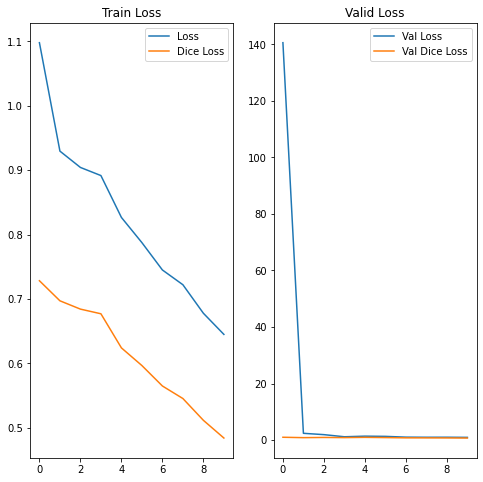

In [126]:
# # Plot the loss
# dice_loss = history.history['dice_loss']
# loss = history.history['loss']
# val_dice_loss = history.history['val_dice_loss']
# val_loss = history.history['val_loss']

# epochs_range = range(max_epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, loss, label='Loss')
# plt.plot(epochs_range, dice_loss, label='Dice Loss')
# plt.legend(loc='upper right')
# plt.title('Train Loss')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, val_loss, label='Val Loss')
# plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
# plt.legend(loc='upper right')
# plt.title('Valid Loss')
# plt.show()

## 비교 Encoder-Decoder

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 14s 232ms/step - loss: 1.4156 - dice_loss: 0.8197 - val_loss: 1.4821 - val_dice_loss: 0.8104
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 7s 205ms/step - loss: 1.1895 - dice_loss: 0.7841 - val_loss: 1.4728 - val_dice_loss: 0.8246
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 7s 206ms/step - loss: 1.0782 - dice_loss: 0.7603 - val_loss: 1.1928 - val_dice_loss: 0.7609
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 7s 205ms/step - loss: 0.9918 - dice_loss: 0.7211 - val_loss: 1.1255 - val_dice_loss: 0.7230
Epoch 5/10

Epoch 00005: LearningRateScheduler setting learning rate to tf.Tensor(0.0006545085, shape=(), dtype=float32).
30/30 [==============================] - 7s 203ms/step - loss: 0.9552 - dice_loss: 0.7107 - val_loss: 1.0615 - val_dice_loss: 0.7494
Epoch 6/10

Epoch 00006: LearningRateScheduler setting learning rate to tf.Tensor(0.00049999997, shape=(), dtype=float32).
30/30 [==============================] - 7s 201ms/step - loss: 0.9388 - dice_loss: 0.7048 - val_loss: 0.9721 - val_dice_loss: 0.7016
Epoch 7/10

Epoch 00007: LearningRateScheduler setting learning rate to tf.Tensor(0.00034549143, shape=(), dtype=float32).
30/30 [==============================] - 7s 200ms/step - loss: 0.9353 - dice_loss: 0.7037 - val_loss: 0.9924 - val_dice_loss: 0.6980
Epoch 8/10

Epoch 00008: LearningRateScheduler setting learning rate to tf.Tensor(0.00020610739, shape=(), dtype=float32).
30/30 [==============================] - 7s 201ms/step - loss: 0.9031 - dice_loss: 0.6806 - val_loss: 0.9663 - val_dice_loss: 0.6892
Epoch 9/10

Epoch 00009: LearningRateScheduler setting learning rate to tf.Tensor(9.549147e-05, shape=(), dtype=float32).
30/30 [==============================] - 7s 200ms/step - loss: 0.8779 - dice_loss: 0.6602 - val_loss: 0.9410 - val_dice_loss: 0.7012
Epoch 10/10

Epoch 00010: LearningRateScheduler setting learning rate to tf.Tensor(2.4471761e-05, shape=(), dtype=float32).
30/30 [==============================] - 7s 201ms/step - loss: 0.8500 - dice_loss: 0.6384 - val_loss: 0.9349 - val_dice_loss: 0.6938

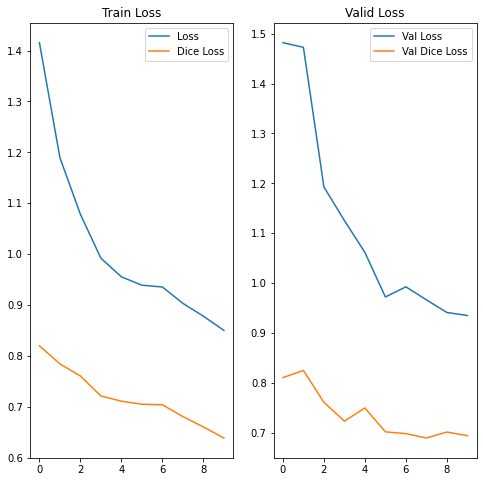

##### 1. 일반 Loss (loss)

기본적인 손실 값으로, U-Net 모델이 예측한 결과와 정답(ground truth) 간의 차이를 의미해.

보통 Binary Cross Entropy(BCE) + Dice Loss 또는 Mean Squared Error(MSE) 를 사용해.

##### 2. Dice Loss (dice_loss)

이미지 분할(segmentation)에서 자주 쓰이는 손실 함수

Dice Coefficient는 두 이미지(예측과 정답)가 얼마나 일치하는지를 0~1 사이 값으로 측정하는 지표야.
→ 1에 가까울수록 좋음

Dice Loss = 1 - Dice Coefficient
→ 손실이 작을수록 모델이 더 좋은 성능을 낸다고 볼 수 있음.

##### 3. 검증 손실 (val_loss, val_dice_loss)

val_loss: 검증(validation) 데이터셋에서의 일반적인 손실 값.

val_dice_loss: 검증 데이터셋에서의 Dice Loss 값.

훈련 데이터의 손실과 비교하여 과적합(overfitting) 여부를 판단할 수 있음.

### Evaluate the test dataset
불러온 가중치를 이용해서 모델을 평가해 봅시다. meanIoU를 metric으로 하여 정량적으로 평가해 볼 수 있고, 실제 생성된 segmentation 이미지를 분석해서 정성적으로 평가해 볼 수 있습니다.

meanIoU란 각 이미지의 IoU 값을 평균 낸 값입니다. IoU는 segmentation 모델을 정량적으로 평가하는데 좋은 metric이 됩니다. 개념은 아래 그림과 같습니다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/e-20-1.png)

In [127]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [128]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.49939763594968134


In [129]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

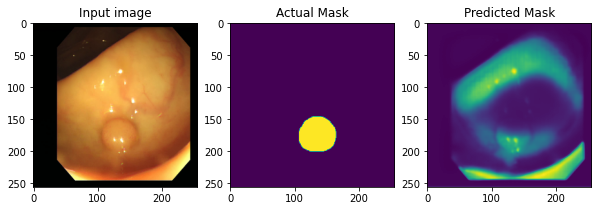

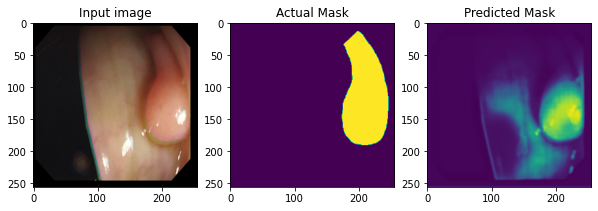

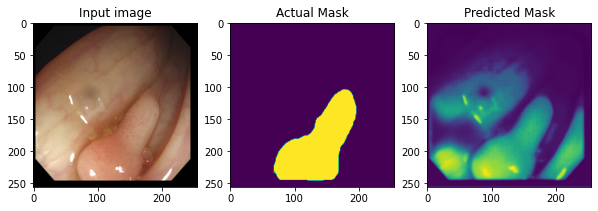

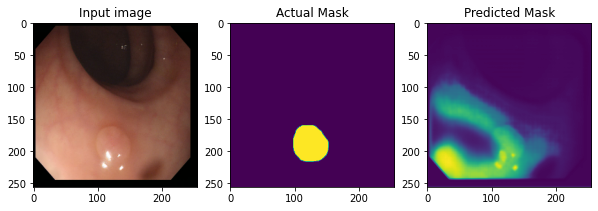

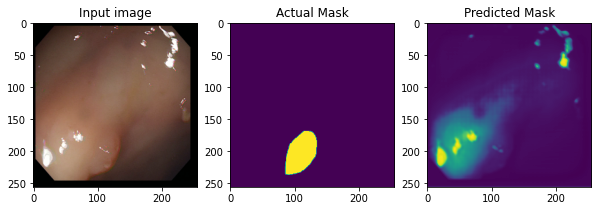

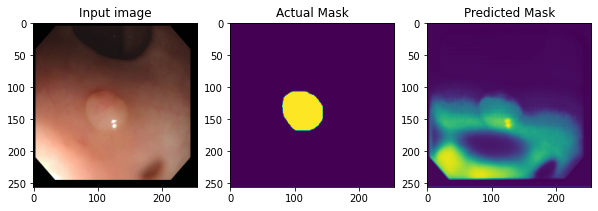

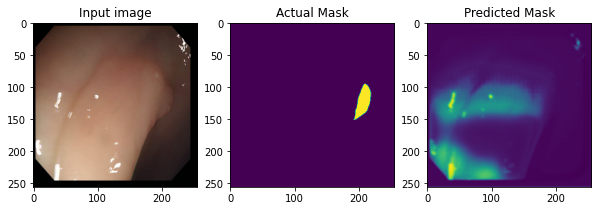

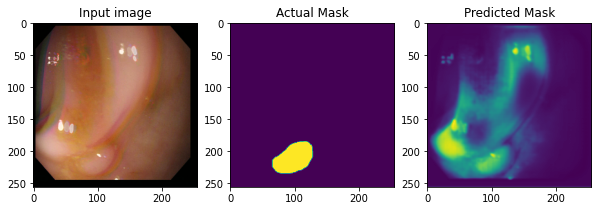

In [130]:
print_images()

### 프로젝트: U-Net 성능 개선해 보기(pretrained 된 VGG16모델)

지금까지 우리는 Encoder-Decoder 모델과 U-Net 모델의 성능 차이를 실험을 통해 살펴보았습니다. 아마도 여러분들은 의료영상 Segmentation 모델을 위해 U-Net을 고려할 가치가 충분하다는 것을 확인할 수 있었을 것입니다.

그러나 이를 개선할 수 있는 방법 또한 무궁무진합니다. U-Net 또한 개선을 거듭해 왔고, 또 U-Net 기반이 아닌 다른 모델들도 많이 나오고 있습니다.

혹시, U-Net의 인코더 모델을 VGG, ResNet 등 기존의 pretrained model을 활용하는 것은 가능할까요? 또 그런 시도를 했을 때 성능 개선 효과가 있을까요?
Pretrained model들은 ImageNet 데이터를 이용해 pretrain된 것이 대부분입니다. 일반적으로는 transfer learning이 훨씬 효과적인 것으로 알려져 있지만, 의료 영상 도메인에도 동일하게 효과적일까요? 오늘의 프로젝트는 그것을 확인해 보는 것으로 하겠습니다.

In [131]:
import tensorflow
import sklearn
import numpy

print(tensorflow.__version__)
print(sklearn.__version__)
print(numpy.__version__)

2.6.0
1.0
1.21.4


In [132]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers] # 모든 layer층 가져오기 나중에 skip connection시 사용 
layer_outputs

[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_4')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'block3_pool')>,


In [133]:

class Vgg16UNet(tf.keras.Model):
    # U-Net의 Skip Connection을 위해 Encoder의 주요 Feature Map을 저장
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,  
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

In [134]:
vgg16_model = Vgg16UNet()

In [135]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

# 위에서 구성한 두가지 모델 중에서 하나를 선택해 주세요. 
# 여기서 선택을 바꾸어 다른 모델의 학습도 진행해 볼 수 있습니다. 

#print('select the Encoder-Decoder model')
#model = ed_model
#checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/ed_model')

print('select the VGG16 model2')
model = vgg16_model
checkpoint_dir =os.path.join(DATASET_PATH,'train_ckpt/VGG16_model')


model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)
model.summary()

select the VGG16 model
(8, 256, 256, 1)
Model: "vgg16u_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
model_1 (Functional)         [(None, 256, 256, 64), (N 14714688  
_________________________________________________________________
conv_block_16 (ConvBlock)    multiple                  0 (unused)
_________________________________________________________________
decoder_block_16 (DecoderBlo multiple                  9444864   
_________________________________________________________________
decoder_block_17 (DecoderBlo multiple                  2952960   
_________________________________________________________________
decoder_block_18 (DecoderBlo multiple                  739200    
_________________________________________________________________
decoder_block_

In [136]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [137]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 21s 596ms/step - loss: 1.0846 - dice_loss: 0.7106 - val_loss: 1.2435 - val_dice_loss: 0.9265
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 19s 576ms/step - loss: 0.8653 - dice_loss: 0.6451 - val_loss: 1.6375 - val_dice_loss: 0.9999
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 18s 574ms/step - loss: 0.8118 - dice_loss: 0.6078 - val_loss: 1.1478 - val_dice_loss: 0.7751
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 18s 570ms/step - loss: 0.7547 - dice_loss: 0.5707 - val_loss: 1.0423 - val

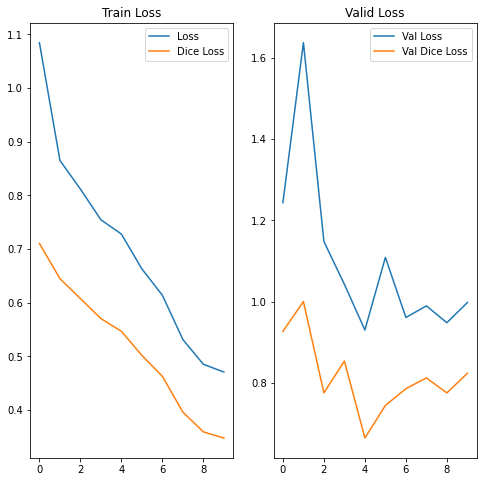

In [138]:
# Plot the loss
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [139]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
checkpoint_dir = os.path.join(DATASET_PATH, 'train_ckpt/VGG16_model')

# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

In [140]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

mean_iou: 0.5144985387002079


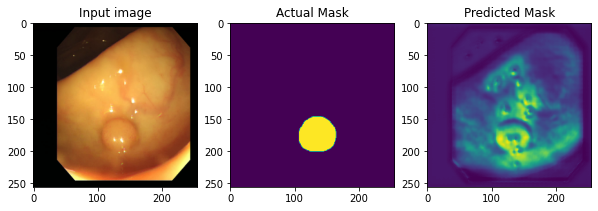

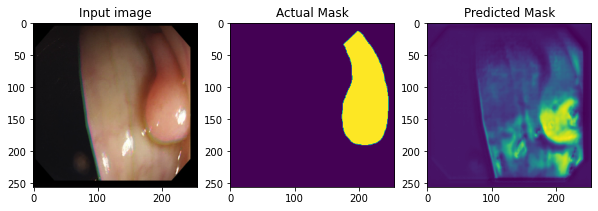

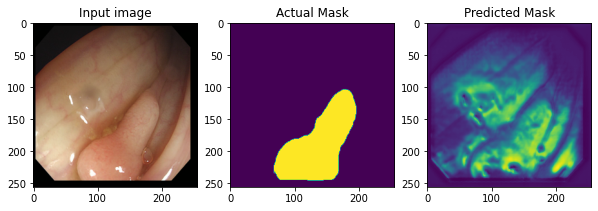

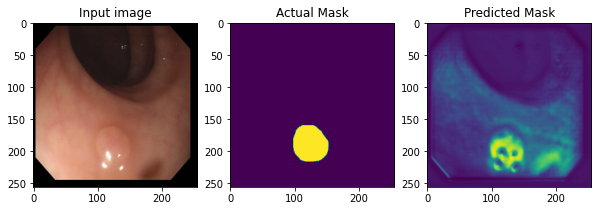

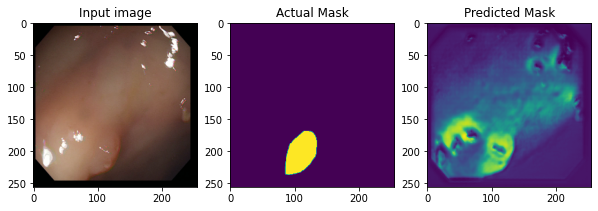

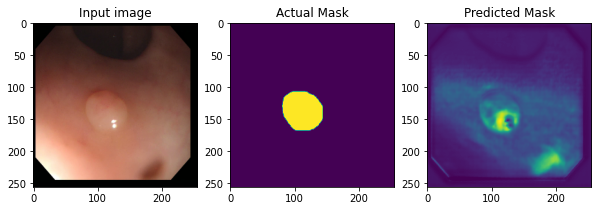

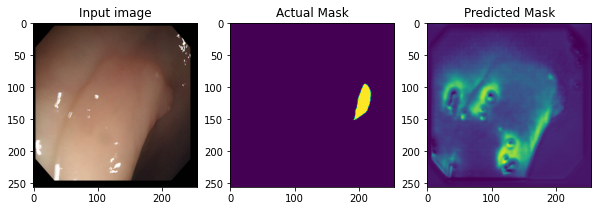

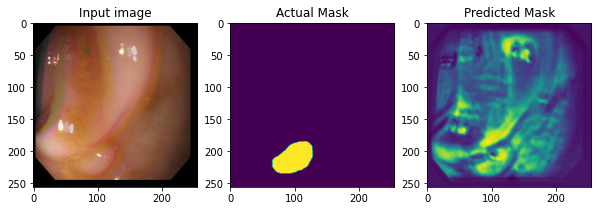

In [141]:
print_images()

### 추가적인 모델 수정
1. VGG16 + U-Net모델을 그대로 적용 + Batch Normalization 추가
2. AdamW 적용

In [216]:
import tensorflow
import sklearn
import numpy

print(tensorflow.__version__)
print(sklearn.__version__)
print(numpy.__version__)

vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
layer_outputs = [layer.output for layer in vgg16.layers] # 모든 layer층 가져오기 나중에 skip connection시 사용 
layer_outputs

class Vgg16UNet2(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet2, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                                 include_top=False,
                                                 weights='imagenet')

        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])

        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

        # Batch Normalization 추가
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.3)

    def call(self, inputs, training=True):
        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs)

        center = self.bn(center, training=training)
        center = self.dropout(center, training=training)

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        outputs = self.output_conv(decoder1)

        return outputs


2.6.0
1.0
1.21.4


In [217]:
vgg16_model2 = Vgg16UNet2()

In [218]:
import tensorflow_addons as tfa  # TensorFlow Addons 불러오기

# 다이스의 계수 계산 방식 조절
def dice_coeff(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    
    return (2. * intersection + smooth) / (union + smooth)


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    bce = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))
    dice = dice_loss(y_true, y_pred)
    return 0.5 * bce + 0.5 * dice  # 가중치 조정 가능 (예: 0.7 * BCE + 0.3 * Dice)

# AdamW 적용 (weight decay 포함)
optimizer = tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)

print('select the VGG16 model2')
model = vgg16_model2
checkpoint_dir = os.path.join(DATASET_PATH, 'train_ckpt/VGG16_model2')

# 모델 컴파일
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])

# 더미 데이터 예측 (디버깅용)
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

# 모델 요약 출력
model.summary()


select the VGG16 model2
(8, 256, 256, 1)
Model: "vgg16u_net2_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
model_16 (Functional)        [(None, 256, 256, 64), (N 14714688  
_________________________________________________________________
conv_block_24 (ConvBlock)    multiple                  0 (unused)
_________________________________________________________________
decoder_block_76 (DecoderBlo multiple                  8128000   
_________________________________________________________________
decoder_block_77 (DecoderBlo multiple                  2294528   
_________________________________________________________________
decoder_block_78 (DecoderBlo multiple                  573824    
_________________________________________________________________
decoder_bloc

In [219]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [220]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
30/30 [==============================] - 18s 487ms/step - loss: 6.0447 - dice_loss: 0.9520 - val_loss: 17.2640 - val_dice_loss: 0.8992
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.00097552827, shape=(), dtype=float32).
30/30 [==============================] - 16s 488ms/step - loss: 1.4957 - dice_loss: 0.9465 - val_loss: 8.2202 - val_dice_loss: 0.9034
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009045085, shape=(), dtype=float32).
30/30 [==============================] - 16s 489ms/step - loss: 0.5874 - dice_loss: 0.8831 - val_loss: 0.6459 - val_dice_loss: 0.8893
Epoch 4/10

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00079389266, shape=(), dtype=float32).
30/30 [==============================] - 16s 484ms/step - loss: 0.5857 - dice_loss: 0.8899 - val_loss: 0.5541 - va

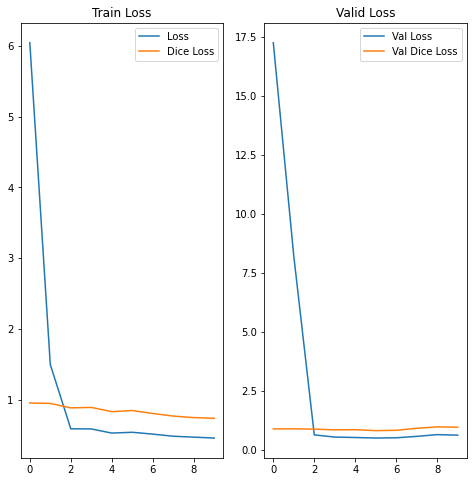

In [221]:
# Plot the loss
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [222]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
checkpoint_dir = os.path.join(DATASET_PATH, 'train_ckpt/VGG16_model2')

# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

In [223]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

mean_iou: 0.5098084656645512


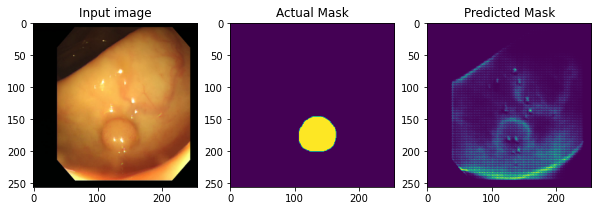

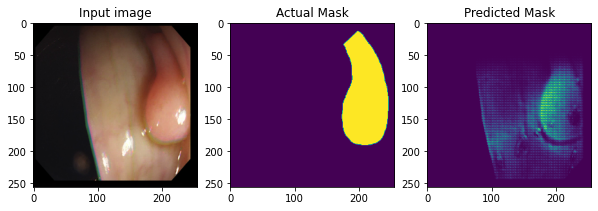

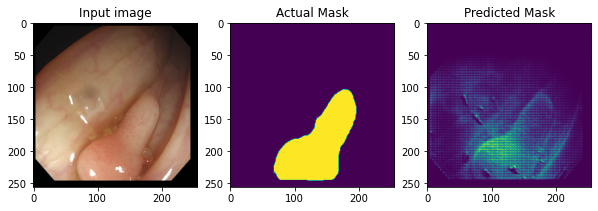

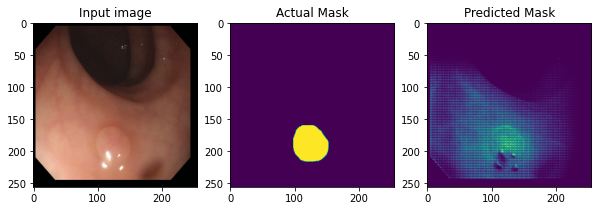

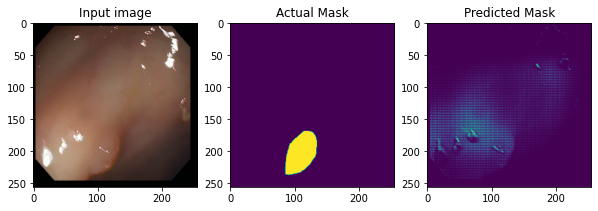

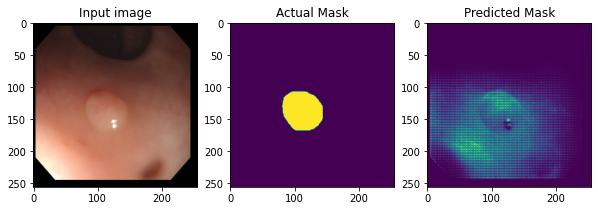

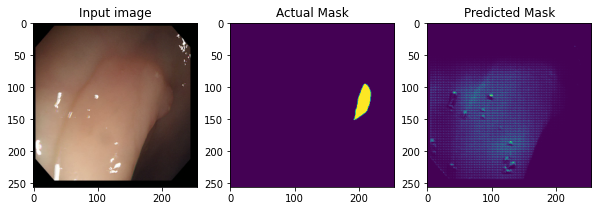

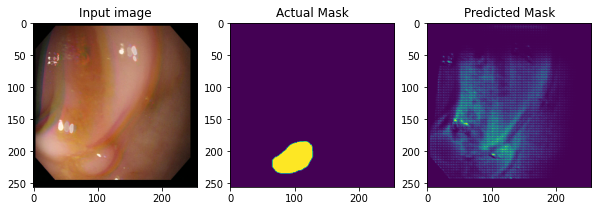

In [224]:
print_images()

### 다른 모델 써보기
1. Resnet + U-Net모델을 적용
2. AdamW 적용

In [229]:
import tensorflow as tf
from tensorflow.keras import layers, models

# img_shape 정의
img_shape = (256, 256, 3)

# ConvBlock (Encoder 블록의 기본 구조)
class ConvBlock(layers.Layer):
    def __init__(self, filters):
        super(ConvBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, (3, 3), padding='same')
        self.conv2 = layers.Conv2D(filters, (3, 3), padding='same')
        self.pool = layers.MaxPooling2D((2, 2))

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        return x

# DecoderBlock (Decoder 블록 구조)
class DecoderBlock(layers.Layer):
    def __init__(self, filters):
        super(DecoderBlock, self).__init__()
        self.upconv = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')
        self.conv1 = layers.Conv2D(filters, (3, 3), padding='same')
        self.conv2 = layers.Conv2D(filters, (3, 3), padding='same')

    def call(self, x, skip):
        x = self.upconv(x)
        x = layers.concatenate([x, skip], axis=-1)  # Skip connection
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# ResNet50 기반 U-Net 모델 정의
class ResNet50UNet(tf.keras.Model):
    def __init__(self, img_shape=(256, 256, 3)):
        super(ResNet50UNet, self).__init__()

        # ResNet50 모델 로드 (pretrained weights 사용)
        self.resnet50 = tf.keras.applications.ResNet50(input_shape=img_shape,
                                                       include_top=False,
                                                       weights='imagenet')

        # ResNet50에서 필요한 feature map 추출 (블록별로 추출)
        layer_outputs = [layer.output for layer in self.resnet50.layers]
        self.resnet50_act = models.Model(inputs=self.resnet50.input, 
                                         outputs=[layer_outputs[2],  # Block1
                                                  layer_outputs[5],  # Block2
                                                  layer_outputs[9],  # Block3
                                                  layer_outputs[13], # Block4
                                                  layer_outputs[17]])# Block5

        # Decoder 블록 정의
        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        # 최종 출력 Conv
        self.output_conv = layers.Conv2D(1, (1, 1), activation='sigmoid')

        # Batch Normalization 추가
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.3)

    def call(self, inputs, training=True):
        # Encoder: ResNet50에서 feature 추출
        encoder1, encoder2, encoder3, encoder4, center = self.resnet50_act(inputs)

        # Batch Normalization과 Dropout을 적용
        center = self.bn(center, training=training)
        center = self.dropout(center, training=training)

        # Decoder: Skip Connection을 사용
        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)

        # 최종 출력
        outputs = self.output_conv(decoder1)

        return outputs

# 모델 인스턴스 생성
model = ResNet50UNet(img_shape=(256, 256, 3))

# 더미 데이터 예측 (디버깅용)
batch_size = 8
image_size = 256
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))  # 256x256 크기 입력
print(predictions.shape)  # 예측된 출력 크기 확인

# 모델 요약 출력
model.summary()


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(8, 128, 128, 512), (8, 64, 64, 256)]

In [228]:
ResNet50_model = ResNet50()

TypeError: 'module' object is not callable

In [199]:
import tensorflow as tf
import tensorflow_addons as tfa

# 이미지 크기와 배치 크기 설정
batch_size = 8
image_size = 256  # 모델에 입력될 이미지 크기

# 다이스 계수 및 손실 함수 정의
def dice_coeff(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    return (2. * intersection + smooth) / (union + smooth)


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    bce = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))
    dice = dice_loss(y_true, y_pred)
    return 0.5 * bce + 0.5 * dice  # 가중치 조정 가능 (예: 0.7 * BCE + 0.3 * Dice)

# AdamW 적용 (weight decay 포함)
optimizer = tfa.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)

# 모델 정의 (ResNet50 모델)
model = ResNet50_model  # ResNet50 모델을 이미 정의한 상태라고 가정
checkpoint_dir = os.path.join(DATASET_PATH, 'train_ckpt/ResNet50_model')

# 모델 컴파일
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])

# 더미 데이터 예측 (디버깅용)
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))  # 256x256 크기 입력
print(predictions.shape)  # 예측된 출력 크기 확인

# 모델 요약 출력
model.summary()


(8, 130, 130, 1)
Model: "res_net50u_net_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
model_8 (Functional)         [(None, 130, 130, 64), (N 9116032   
_________________________________________________________________
conv_block_23 (ConvBlock)    multiple                  0 (unused)
_________________________________________________________________
decoder_block_44 (DecoderBlo multiple                  11798016  
_________________________________________________________________
decoder_block_45 (DecoderBlo multiple                  2654976   
_________________________________________________________________
decoder_block_46 (DecoderBlo multiple                  663936    
_________________________________________________________________
decoder_block_47 (DecoderBlo mult

In [200]:
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /tmp/ipykernel_31/2513916708.py:25 bce_dice_loss  *
        bce = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/losses.py:1809 binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/backend.py:5000 binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:245 sigmoid_cross_entropy_with_logits_v2
        return sigmoid_cross_entropy_with_logits(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 130, 130, 1) vs (None, 256, 256, 1))


### 회고

1. 처음에 실수로 U-net의 완벽히 Train된 모델을 불러와서 혼란이 왔다.
2. 이후 실수를 깨닫고 수정했더니 형편없는결과가 나왔다
3. VGG16+U-net모델은 조금더 괜찮은 성능이었지만 이 역시도 많이 부족
4. VGG16+Unet 모델을 수정하는 방법으로 BatchNomalization과 weight_decay를 적용해서 약간의 개선을 얻음
5. 이후 ResNet모델 Dense모델을 써볼려고 했으나 shape의 충돌로 완성하지 못함

생각보다 개선을 위해서 할수있는 방법을 많이 적용하지 못했고
다른 모델을 쓸려고 할때 나는 충돌문제를 해결하지 못해서 부족함을 많이 느낀 하루였다.